### Приложен ноутбук, в котором реализованы функции для генирации из большого датасета в меньшую его копию. Вам нужно перенести функции из этого ноутбука в класс датасет и сделать следующее: 
- Сгенерировать меньший датасет из 8-10 классов движения  
- Обучить уже существующую модель (предварительно проанализировав какие параметры модели нужно изменить)  
- Изменить модель: посмотреть зависимость от количества LSTM модулей в нашей модели   
- Сгенерировать другой датасет с меньшим количеством “кадров” в серии и сравнить улучшилось или ухудшилось качество предсказания. Провести несколько таких итераций, дать свою оценку уменьшению и увеличению кадров, назвать оптимальное, на ваш взгляд, их количество. Желательно сделать так, чтобы длина последовательности передавалась как атрибут класса.


In [1]:
import os
import time
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

from pathlib import Path
import zipfile
from zipfile import ZipFile

In [2]:
file_path = "/content/drive/MyDrive/nturgbd_skeletons_s001_to_s017.zip"
zipfile = ZipFile(file_path)
zipfile.extractall()

In [3]:
PATH_TO_DATA = "/content/nturgb+d_skeletons"
#### список отсутсвующих элементов так же будет доступен 
PATH_TO_BROKEN_DATA = "/content/drive/MyDrive/NTU_RGBD_samples_with_missing_skeletons.txt"

In [4]:
training_subjects = list(range(0, 28)) #количество людей выполняющих действия
training_classes = [1, 5, 7, 8, 10, 22, 23, 27, 21, 43] # классы которые будем использовать для обучения, полный список прдставлен тут https://github.com/shahroudy/NTURGB-D
training_cameras = [1, 2, 3] 
max_body_true = 1
max_body_kinect = 1
num_joint = 25
max_frame = 300 # Длина отрезка которую мы вычленяем из большого датасета

In [5]:
labelsDict = {1: 'drink water', 
          5: 'drop', 
          7: 'throw', 
          8: 'sitting down', 
          10: 'clapping', 
          22: 'cheer up', 
          23: 'hand waving', 
          27: 'jump up', 
          21: 'take off a hat/cap', 
          43: 'falling'}
LABELS = list(labelsDict.values())
training_classes = list(labelsDict.keys())

In [6]:
class ProcessingDataset:
    
    files = None
    action_classes = None
    
    def __init__(self, data_path, broken_files_path , chonk_len=45):
        self.data_path = data_path
        self.broken_files_path = broken_files_path
        self.chonk_len = chonk_len
    
    def read_data(self):
        labels = []
        files = []
        action_classes = {}
        counter = 0
        files_counter = {}

        with open(self.broken_files_path, 'r') as f:
            broken_files = f.read().split("\n")

        raw_files = os.listdir(self.data_path)
        num_frames = 0

        for filename in raw_files:
            if filename not in broken_files:
                action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
                subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
                camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
                if action_class in training_classes and camera_id in training_cameras:  # and subject_id in training_subjects:
                    if action_class in action_classes:
                        if files_counter[action_class] < 120:
                            files.append([filename, action_classes[action_class]])
                            files_counter[action_class] = files_counter[action_class] + 1
                    else:
                        action_classes.update({action_class : counter})
                        files_counter.update({action_class : 1})
                        counter+=1
                        files.append([filename,action_classes[action_class]])
                        labels.append([action_class])
                        
        print("action classes: ", action_classes)
        print("action files: ", files_counter)
        
        self.files = files
        self.action_classes = action_classes
        
        return files, action_classes
    
    def get_nonzero_std(self, s): 
        index = s.sum(-1).sum(-1) != 0  
        s = s[index]
        if len(s) != 0:
            s = s[:, :, 0].std() + s[:, :, 1].std() + s[:, :, 2].std()  
        else:
            s = 0
        return s
    
    def read_skeleton_filter(self, file):
        with open(file, 'r') as f:
            skeleton_sequence = {}
            skeleton_sequence['numFrame'] = int(f.readline())
            skeleton_sequence['frameInfo'] = []
            for t in range(skeleton_sequence['numFrame']):
                frame_info = {}
                frame_info['numBody'] = int(f.readline())
                frame_info['bodyInfo'] = []

                for m in range(frame_info['numBody']):
                    body_info = {}
                    body_info_key = [
                        'bodyID', 'clipedEdges', 'handLeftConfidence',
                        'handLeftState', 'handRightConfidence', 'handRightState',
                        'isResticted', 'leanX', 'leanY', 'trackingState'
                    ]
                    body_info = {
                        k: float(v)
                        for k, v in zip(body_info_key, f.readline().split())
                    }
                    body_info['numJoint'] = int(f.readline())
                    body_info['jointInfo'] = []
                    for v in range(body_info['numJoint']):
                        joint_info_key = [
                            'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                            'orientationW', 'orientationX', 'orientationY',
                            'orientationZ', 'trackingState'
                        ]
                        joint_info = {
                            k: float(v)
                            for k, v in zip(joint_info_key, f.readline().split())
                        }
                        body_info['jointInfo'].append(joint_info)
                    frame_info['bodyInfo'].append(body_info)
                skeleton_sequence['frameInfo'].append(frame_info)

        return skeleton_sequence
    
    def read_xyz(self, file, max_body=1, num_joint=25):
        seq_info = self.read_skeleton_filter(file)
        data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
        for n, f in enumerate(seq_info['frameInfo']):
            for m, b in enumerate(f['bodyInfo']):
                for j, v in enumerate(b['jointInfo']):
                    if m < max_body and j < num_joint:
                        data[m, n, j, :] = [v['x'], v['y'], v['z']]

                    else:
                        pass

        return data
    
    def create_coords_blocks(self, test_file):   
        frame_counter = 0
        new_labels = []
        new_frames = []
        blocks = []

        test_frames = self.read_xyz(self.data_path+'/'+test_file[0])[0]
        label = test_file[1]
        slice_len = self.chonk_len * int(len(test_frames)/self.chonk_len)


        for index in range(len(test_frames[:slice_len])):
            frame_counter += 1
            new_frames.append(test_frames[index].flatten())
            if frame_counter == self.chonk_len:
                frame_counter = 0
                blocks.append(np.array(new_frames))
                new_labels = new_labels + [label]
                new_frames = []


        return blocks, new_labels
    
    def mark_data(self):
        data = []
        labels = []
        ##########################################################################
        numbers = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0} #####
        ##################################################################
        for file in self.files:
            frames_blocks, label = self.create_coords_blocks(file)
            if label != [] and numbers[label[0]] <= 150:
                numbers[label[0]] += len(label)
                data += frames_blocks
                labels += label
        data_np = np.asarray(data)
        labels_np = np.asarray(labels)

        data_sq = data_np.reshape(len(data_np), -1)
        test_data = pd.DataFrame(data_sq)
        test_labels = pd.DataFrame(labels_np)
        test_data['labels'] = test_labels
        
        return test_data

In [7]:
def net_result(model, test_loader):
    total = 0
    right = 0
    counter = 0

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            counter = counter + 1
            inputs, labels = data[0].to(device), data[1].to(device)  
            output = model(inputs.float())
            guess, guess_i = categoryFromOutput(output)
            category = LABELS[int(labels[0])]

            if guess == category:
                right = right + 1


    return 100 * right / counter

In [8]:
chonk_len=35
dataset_35 = ProcessingDataset(data_path=PATH_TO_DATA, broken_files_path=PATH_TO_BROKEN_DATA, chonk_len=chonk_len)
dataset_35.read_data()

test_data = dataset_35.mark_data()
test_data.info()
test_data.head()

action classes:  {5: 0, 43: 1, 1: 2, 8: 3, 27: 4, 21: 5, 10: 6, 23: 7, 7: 8, 22: 9}
action files:  {5: 120, 43: 120, 1: 120, 8: 120, 27: 120, 21: 120, 10: 120, 23: 120, 7: 120, 22: 120}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Columns: 2626 entries, 0 to labels
dtypes: float64(2625), int64(1)
memory usage: 30.1 MB


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2586,2587,2588,2589,2590,2591,2592,2593,2594,2595,2596,2597,2598,2599,2600,2601,2602,2603,2604,2605,2606,2607,2608,2609,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620,2621,2622,2623,2624,labels
0,0.033627,-0.153151,2.947184,0.057664,0.113258,2.884437,0.079012,0.373884,2.808054,0.069472,0.502320,2.768429,-0.082930,0.292054,2.892936,-0.108795,0.065490,2.881835,-0.105479,-0.107099,2.725327,-0.102046,-0.208768,2.666173,0.209580,0.258456,2.813260,0.251901,0.043980,2.871995,0.137642,-0.142028,2.747920,0.141629,-0.188562,2.742828,-0.041047,-0.131260,2.925301,-0.001407,...,-0.036949,-0.135196,2.959858,-0.002236,-0.438685,3.108943,0.015615,-0.758132,3.250247,0.022046,-0.807991,3.112280,0.086727,-0.149378,2.920350,0.144645,-0.467821,3.035475,0.177556,-0.770041,3.167409,0.191991,-0.835674,3.040912,0.066497,0.304804,2.817487,-0.119674,-0.264081,3.027590,-0.143341,-0.194467,2.998917,0.197069,-0.318737,2.854410,0.222696,-0.253644,2.834100,0
1,0.026151,-0.144741,2.972513,0.049725,0.114460,2.887705,0.071193,0.366430,2.790543,0.048262,0.496761,2.745136,-0.080247,0.300407,2.908142,-0.110213,0.073506,2.987541,-0.118906,-0.141023,3.000468,-0.119358,-0.204869,2.999348,0.199836,0.251698,2.788830,0.224245,0.019738,2.834923,0.217896,-0.181768,2.838578,0.199695,-0.255245,2.852775,-0.035722,-0.136785,2.960216,-0.000744,...,-0.034575,-0.133158,2.958498,-0.003312,-0.418237,3.098740,0.019536,-0.709465,3.238883,-0.013808,-0.771090,3.134406,0.094906,-0.148150,2.926291,0.147972,-0.423351,3.003628,0.167753,-0.749125,3.171634,0.132973,-0.810257,3.067311,0.077280,0.309707,2.832952,-0.126652,-0.269714,3.016581,-0.137994,-0.196149,2.983298,0.186449,-0.296607,2.850079,0.215320,-0.228968,2.839952,0
2,-0.060357,-0.315068,2.403249,-0.054465,-0.035722,2.336251,-0.048184,0.237548,2.258005,-0.064239,0.360218,2.233714,-0.201011,0.121723,2.291301,-0.225411,-0.124998,2.344790,-0.213907,-0.345187,2.335433,-0.195106,-0.379796,2.348070,0.095114,0.118406,2.251798,0.130680,-0.122229,2.304724,0.125005,-0.314931,2.305791,0.104975,-0.382855,2.313406,-0.129545,-0.310719,2.376342,-0.113018,...,-0.110852,-0.341964,2.377876,-0.116116,-0.597428,2.380072,-0.122223,-0.843072,2.523622,-0.129876,-0.888671,2.432871,0.030332,-0.356749,2.368085,0.012368,-0.590427,2.352786,0.008187,-0.846971,2.499638,-0.001047,-0.892428,2.408899,0.007457,0.082186,2.208422,-0.243388,-0.426965,2.387200,-0.272014,-0.353343,2.345586,0.248311,-0.503846,2.296074,0.277831,-0.456191,2.270462,1
3,-0.034709,-0.374870,2.415974,-0.007040,-0.131065,2.300214,0.020636,0.105112,2.169716,0.040490,0.220575,2.105205,-0.144879,0.065598,2.216219,-0.222866,-0.136226,2.336989,-0.252782,-0.344223,2.356483,-0.250114,-0.385126,2.364420,0.160819,0.015382,2.193609,0.229106,-0.187345,2.289704,0.262716,-0.389334,2.294454,0.265643,-0.471430,2.297677,-0.105475,-0.361853,2.387802,-0.122932,...,0.187078,-0.948533,2.412732,-0.005584,-0.912429,2.254728,0.294728,-1.015307,2.235359,0.265007,-1.019153,2.115911,0.314934,-0.968266,2.430190,0.518598,-0.898465,2.322140,0.259979,-0.971274,2.077842,0.239759,-1.023768,2.067065,0.303609,-0.676211,2.081669,-0.051312,-1.017699,2.188394,0.040440,-1.002223,2.108441,0.286199,-1.029478,2.202228,0.302829,-1.023747,2.213833,1
4,-0.228192,-0.520000,3.838202,-0.243039,-0.325795,3.867665,-0.259306,-0.133248,3.885972,-0.311593,-0.017658,3.875495,-0.378982,-0.234225,3.962538,-0.371144,-0.409475,3.701077,-0.318974,-0.263689,3.528335,-0.301931,-0.215465,3.474260,-0.116761,-0.193644,3.797601,0.016079,-0.336040,3.671027,-0.238833,-0.272825,3.616122,-0.297410,-0.272147,3.608437,-0.285097,-0.533094,3.858177,-0.319357,...,-0.287733,-0.538657,3.845937,-0.312125,-0.299946,3.673370,-0.179968,-0.480791,3.897000,-0.238121,-0.569714,3.810833,-0.171717,-0.503865,3.750650,-0.125512,-0.652447,3.534055,-0.054114,-0.740236,3.825849,-0.088739,-0.721357,3.677274,-0.261034,-0.171389,3.875736,-0.406630,-0.441772,3.60110

In [9]:
test_data.to_csv("/content/drive/MyDrive/skeletons_classes_1_30_35.csv", index=False)

In [10]:
class LSTM_net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layer_num):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_num, batch_first=True)
        self.dr = nn.Dropout2d(0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self,inputs):
        x = inputs
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [11]:
# LSTM setups
rnn = LSTM_net(
    input_dim=25*3,
    hidden_dim=128,
    output_dim=len(training_classes),
    layer_num=1
)
rnn.to('cpu')

LSTM_net(
  (lstm): LSTM(75, 128, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [12]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.labels = self.data.iloc[:,-1]

    def __len__(self):
        return len(self.data) 
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(chonk_len, 75)
        label = self.labels[idx]
        
        if self.transform != None:
            item = transform(item)

        return (item, label)

In [13]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {round(s)}s'

In [14]:
dataset = Skeleton_Dataset(file_path = "/content/drive/MyDrive/skeletons_classes_1_30_35.csv", transform=None)

train_len = int(0.75*len(dataset))
test_len = len(dataset) - train_len

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_len, test_len])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [15]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    params=rnn.parameters(), 
    lr=0.001, 
    momentum=0.9
)

all_losses = []
start = time.time()
counter = 0

for epoch in range(200):
    current_loss = 0
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else f'✗ ({category})'
            print(f'epoch = {epoch}; iter = {i}; time = {timeSince(start)}; loss = {loss}  / {guess} {correct}')

        counter += 1
                  
        if counter % 100 == 0:
            all_losses.append(current_loss / 25)
            current_loss = 0

epoch = 0; iter = 0; time = 0m 1s; loss = 2.294828414916992  / hand waving ✗ (cheer up)
epoch = 7; iter = 3; time = 0m 25s; loss = 2.0201332569122314  / clapping ✗ (falling)
epoch = 14; iter = 6; time = 0m 49s; loss = 2.0344955921173096  / throw ✗ (falling)
epoch = 21; iter = 9; time = 1m 13s; loss = 1.8282055854797363  / clapping ✗ (throw)
epoch = 28; iter = 12; time = 1m 37s; loss = 1.708974003791809  / clapping ✗ (sitting down)
epoch = 35; iter = 15; time = 2m 2s; loss = 1.9730720520019531  / cheer up ✗ (jump up)
epoch = 42; iter = 18; time = 2m 26s; loss = 1.4649779796600342  / hand waving ✗ (cheer up)
epoch = 49; iter = 21; time = 2m 54s; loss = 1.7072367668151855  / hand waving ✗ (throw)
epoch = 56; iter = 24; time = 3m 20s; loss = 1.3794174194335938  / clapping ✓
epoch = 63; iter = 27; time = 3m 44s; loss = 1.9173585176467896  / drop ✓
epoch = 70; iter = 30; time = 4m 8s; loss = 1.224362850189209  / clapping ✗ (take off a hat/cap)
epoch = 77; iter = 33; time = 4m 31s; loss = 0.9

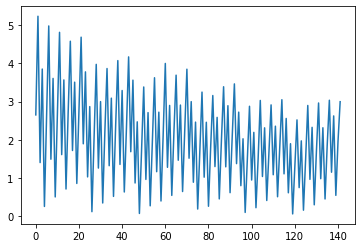

In [16]:
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [17]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0], data[1]
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network: ',  (100 * right / counter))

Accuracy of the network:  48.93617021276596


45 кадров

In [18]:
chonk_len=45
dataset_45 = ProcessingDataset(data_path=PATH_TO_DATA, broken_files_path=PATH_TO_BROKEN_DATA, chonk_len=chonk_len)
dataset_45.read_data()

test_data = dataset_45.mark_data()
test_data.info()
test_data.head()

action classes:  {5: 0, 43: 1, 1: 2, 8: 3, 27: 4, 21: 5, 10: 6, 23: 7, 7: 8, 22: 9}
action files:  {5: 120, 43: 120, 1: 120, 8: 120, 27: 120, 21: 120, 10: 120, 23: 120, 7: 120, 22: 120}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Columns: 3376 entries, 0 to labels
dtypes: float64(3375), int64(1)
memory usage: 33.4 MB


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3336,3337,3338,3339,3340,3341,3342,3343,3344,3345,3346,3347,3348,3349,3350,3351,3352,3353,3354,3355,3356,3357,3358,3359,3360,3361,3362,3363,3364,3365,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,0.033627,-0.153151,2.947184,0.057664,0.113258,2.884437,0.079012,0.373884,2.808054,0.069472,0.502320,2.768429,-0.082930,0.292054,2.892936,-0.108795,0.065490,2.881835,-0.105479,-0.107099,2.725327,-0.102046,-0.208768,2.666173,0.209580,0.258456,2.813260,0.251901,0.043980,2.871995,0.137642,-0.142028,2.747920,0.141629,-0.188562,2.742828,-0.041047,-0.131260,2.925301,-0.001407,...,-0.033736,-0.142514,2.959842,0.003175,-0.443057,3.113002,0.010585,-0.719360,3.221980,-0.022837,-0.780475,3.095941,0.090728,-0.153848,2.919963,0.146937,-0.471219,3.037755,0.173830,-0.765162,3.169876,0.192267,-0.832034,3.044991,0.064076,0.301602,2.813618,-0.124276,-0.277662,3.019283,-0.142917,-0.190381,2.975800,0.194781,-0.312216,2.858079,0.215069,-0.252754,2.839737,0
1,0.028919,-0.149628,2.971841,0.049282,0.110694,2.885262,0.068725,0.364230,2.786737,0.056133,0.497276,2.747767,-0.082974,0.298244,2.898564,-0.114445,0.071609,2.978092,-0.114726,-0.138204,2.980893,-0.118048,-0.211513,2.984320,0.200553,0.250243,2.787853,0.224500,0.014572,2.839200,0.219160,-0.170573,2.842018,0.191736,-0.242825,2.848997,-0.033612,-0.142304,2.958782,0.003221,...,-0.034415,-0.130673,2.971580,-0.007815,-0.410452,3.101832,0.013802,-0.701678,3.235605,-0.017909,-0.763384,3.130362,0.096103,-0.143784,2.938400,0.147154,-0.423934,3.014762,0.165649,-0.754933,3.175089,0.096619,-0.809570,3.208984,0.072275,0.317296,2.852209,-0.122386,-0.262642,3.021309,-0.143454,-0.202797,2.998062,0.196272,-0.304782,2.873741,0.210538,-0.265583,2.862530,0
2,-0.060357,-0.315068,2.403249,-0.054465,-0.035722,2.336251,-0.048184,0.237548,2.258005,-0.064239,0.360218,2.233714,-0.201011,0.121723,2.291301,-0.225411,-0.124998,2.344790,-0.213907,-0.345187,2.335433,-0.195106,-0.379796,2.348070,0.095114,0.118406,2.251798,0.130680,-0.122229,2.304724,0.125005,-0.314931,2.305791,0.104975,-0.382855,2.313406,-0.129545,-0.310719,2.376342,-0.113018,...,-0.077856,-0.694593,2.586912,-0.105284,-0.826855,2.247374,-0.082221,-1.039668,2.403646,-0.083264,-0.969701,2.298312,0.070762,-0.726508,2.581416,0.046181,-0.830882,2.239552,0.017959,-1.030892,2.318568,0.023921,-1.070882,2.367448,0.073388,-0.397520,2.220912,-0.256133,-0.900960,2.110958,-0.271138,-0.852789,2.123000,0.455086,-0.987624,2.310290,0.458416,-0.952753,2.305300,1
3,-0.228192,-0.520000,3.838202,-0.243039,-0.325795,3.867665,-0.259306,-0.133248,3.885972,-0.311593,-0.017658,3.875495,-0.378982,-0.234225,3.962538,-0.371144,-0.409475,3.701077,-0.318974,-0.263689,3.528335,-0.301931,-0.215465,3.474260,-0.116761,-0.193644,3.797601,0.016079,-0.336040,3.671027,-0.238833,-0.272825,3.616122,-0.297410,-0.272147,3.608437,-0.285097,-0.533094,3.858177,-0.319357,...,-0.273018,-0.529141,3.849599,-0.313979,-0.294456,3.681080,-0.109472,-0.423860,3.916762,-0.174036,-0.511751,3.834843,-0.160049,-0.505127,3.760001,-0.100160,-0.713938,3.550951,-0.103975,-0.565888,3.829729,-0.118058,-0.614242,3.688137,-0.255937,-0.178119,3.877285,-0.151303,-0.181703,3.521208,-0.154717,-0.192269,3.506026,-0.374345,-0.261259,3.605936,-0.332632,-0.301978,3.612667,2
4,-0.224329,-0.522362,3.839178,-0.241808,-0.326058,3.863307,-0.259380,-0.132191,3.877748,-0.312961,-0.015856,3.873147,-0.381161,-0.224099,3.967323,-0.383551,-0.396628,3.705193,-0.252118,-0.248610,3.589400,-0.208663,-0.199637,3.554341,-0.122357,-0.192900,3.792750,0.019076,-0.334376,3.677635,-0.269203,-0.269159,3.604184,-0.315503,-0.266292,3.604716,-0.280228,-0.530123,3.852633,-0.314849,...,-0.272489,-0.568234,3.843274,-0.240500,-0.377471,3.626212,0.017963,-0.679025,3.793714,-0.082625,-0.733622,3.725518,-0.133481,-0.536560,3.764056,-0.184484,-0.708299,3.546436,0.025392,-0.582515,3.746847,0.002944,-0.660984,3.628452,-0.191991,-0.134377,3.893709,-0.285022,0

In [19]:
test_data.to_csv("/content/drive/MyDrive/skeletons_classes_1_30_45.csv", index=False)

In [20]:
class LSTM_net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layer_num):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_num, batch_first=True)
        self.dr = nn.Dropout2d(0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self,inputs):
        x = inputs
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [21]:
rnn = LSTM_net(
    input_dim=25*3,
    hidden_dim=128,
    output_dim=len(training_classes),
    layer_num=1
)
rnn.to('cpu')

LSTM_net(
  (lstm): LSTM(75, 128, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [22]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.labels = self.data.iloc[:,-1]

    def __len__(self):
        return len(self.data) 
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(chonk_len, 75)
        label = self.labels[idx]
        
        if self.transform != None:
            item = transform(item)

        return (item, label)

In [23]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {round(s)}s'

In [24]:
dataset = Skeleton_Dataset(file_path = "/content/drive/MyDrive/skeletons_classes_1_30_45.csv", transform=None)

train_len = int(0.75*len(dataset))
test_len = len(dataset) - train_len

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_len, test_len])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [25]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    params=rnn.parameters(), 
    lr=0.001, 
    momentum=0.9
)

all_losses = []
start = time.time()
counter = 0

for epoch in range(200):
    current_loss = 0
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else f'✗ ({category})'
            print(f'epoch = {epoch}; iter = {i}; time = {timeSince(start)}; loss = {loss}  / {guess} {correct}')

        counter += 1
                  
        if counter % 100 == 0:
            all_losses.append(current_loss / 25)
            current_loss = 0

epoch = 0; iter = 0; time = 0m 0s; loss = 2.2656679153442383  / drop ✗ (drink water)
epoch = 8; iter = 12; time = 0m 32s; loss = 2.209252119064331  / throw ✗ (drop)
epoch = 16; iter = 24; time = 1m 2s; loss = 1.9030596017837524  / throw ✗ (hand waving)
epoch = 24; iter = 36; time = 1m 37s; loss = 1.538069725036621  / falling ✗ (throw)
epoch = 32; iter = 48; time = 2m 8s; loss = 1.647177815437317  / sitting down ✗ (drink water)
epoch = 40; iter = 60; time = 2m 37s; loss = 2.425236701965332  / drop ✗ (sitting down)
epoch = 49; iter = 11; time = 3m 7s; loss = 1.652931809425354  / drink water ✗ (clapping)
epoch = 57; iter = 23; time = 3m 37s; loss = 1.1725460290908813  / take off a hat/cap ✗ (jump up)
epoch = 65; iter = 35; time = 4m 8s; loss = 1.6888104677200317  / sitting down ✓
epoch = 73; iter = 47; time = 4m 38s; loss = 1.3425153493881226  / drop ✓
epoch = 81; iter = 59; time = 5m 9s; loss = 1.1823148727416992  / cheer up ✗ (hand waving)
epoch = 90; iter = 10; time = 5m 39s; loss = 1.

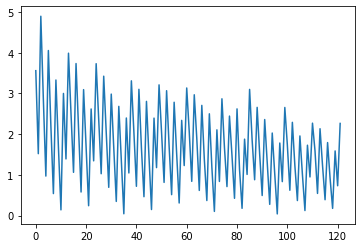

In [26]:
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [27]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0], data[1]
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1

print('Accuracy of the network: ',  (100 * right / counter))

Accuracy of the network:  61.72839506172839


In [28]:
dataset = Skeleton_Dataset(file_path = "/content/drive/MyDrive/skeletons_classes_1_30_45.csv", transform=None)

train_len = int(0.75*len(dataset))
test_len = len(dataset) - train_len

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_len, test_len])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cpu')

In [30]:
result={}
for l in [2, 4, 6]:
    model = LSTM_net(25*3,128,len(training_classes),l)
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.0007
    optimizer = optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9)

    all_losses = []
    start = time.time()
    counter = 0
    for epoch in range(100):  
        current_loss = 0
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):

            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            output = model(inputs.float())
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step() 


            current_loss += loss.item()
            category = LABELS[int(labels[0])]

            if counter % 500 == 0:
                guess, guess_i = categoryFromOutput(output)
                correct = '✓' if guess == category else '✗ (%s)' % category
                print(f'epoch = {epoch}; iter = {i}; time = {timeSince(start)}; loss = {loss}  / {guess} {correct}')


            counter = counter + 1
        if counter % 100 == 0:
            all_losses.append(current_loss / 25)
            current_loss = 0
            
    
    result['l'+ str(l) + '45_кадров_'+'epoch=100'] = net_result(model, test_loader)

epoch = 0; iter = 0; time = 0m 0s; loss = 2.302267551422119  / take off a hat/cap ✗ (jump up)
epoch = 8; iter = 12; time = 0m 42s; loss = 2.307436943054199  / sitting down ✗ (hand waving)
epoch = 16; iter = 24; time = 1m 24s; loss = 2.2880098819732666  / cheer up ✗ (hand waving)
epoch = 24; iter = 36; time = 2m 6s; loss = 2.093402147293091  / drop ✗ (take off a hat/cap)
epoch = 32; iter = 48; time = 2m 48s; loss = 2.143681287765503  / throw ✓
epoch = 40; iter = 60; time = 3m 30s; loss = 1.7200261354446411  / falling ✗ (throw)
epoch = 49; iter = 11; time = 4m 13s; loss = 1.461870789527893  / drop ✓
epoch = 57; iter = 23; time = 4m 56s; loss = 1.8863433599472046  / sitting down ✗ (cheer up)
epoch = 65; iter = 35; time = 5m 38s; loss = 1.4094908237457275  / clapping ✓
epoch = 73; iter = 47; time = 6m 21s; loss = 1.478963851928711  / jump up ✗ (hand waving)
epoch = 81; iter = 59; time = 7m 3s; loss = 1.4918835163116455  / drop ✓
epoch = 90; iter = 10; time = 7m 46s; loss = 1.64556610584259

In [31]:
pd.DataFrame.from_dict(result, orient='index', columns = ['acc_test'])

,acc_test
l245_кадров_epoch=100,45.061728
l445_кадров_epoch=100,9.567901
l645_кадров_epoch=100,9.567901


При увеличении числа lstm слоев:  
- Удалось проверить работу на 1, 2, 4 и 6 слоев на 100 эпохах
- 1 и 2 слоя при увеличении количества слоев до 2 скорость обучения падает, точность обучения возрастает более плавно
- 4 и 6 слоев - модель не обучается выдает один параметр.

При увелчении числа кадров с 35 до 45 получил следующие результаты на 200 эпохах:
- Скорость обучения падает
- Точность возрастает